## Importing Packages

In [29]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## Path Location

### Input Path

In [70]:
BASE_PATH = "H:/files/Adrian pyimage/custom_object_detector/bounding-box-regression/dataset/"

IMAGES_PATH = os.path.join(BASE_PATH, "images")
ANNOTS_PATH = os.path.join(BASE_PATH, "airplanes.csv")


### Output Path

In [8]:

BASE_OUTPUT = "H:/files/Adrian pyimage/custom_object_detector/my_model/output/"

MODEL_PATH = os.path.join(BASE_OUTPUT, "detector.h5")
PLOT_PATH = os.path.join(BASE_OUTPUT, "plot.png")
TEST_FILENAMES = os.path.join(BASE_OUTPUT, "test_images.txt")

## Loading annotation file

In [100]:
rows = open(ANNOTS_PATH).read().strip().split("\n")

data = []
targets = []
filenames = []

for row in rows:
    
    row = row.split(",")
    (filename, startX, startY, endX, endY) = row


    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]



    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h


    image = load_img(imagePath, target_size=(150, 150))
    image = img_to_array(image)
    
    (h, w) = image.shape[:2]
    startX = float(startX) * w
    startY = float(startY) * h
    endX = float(endX) * w
    endY = float(endY) * h


    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

## Rescaling Images and Saving Test Images

In [101]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")


split = train_test_split(data, targets, filenames, test_size=0.10,random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

#Saving test images
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

## Importing ResNEt 152 V2 model

In [12]:
import tensorflow as tf

pre_trained_model = tf.keras.applications.ResNet152V2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(150, 150, 3))

234553344/234545216 [==============================] - 856s 4us/step


In [13]:
pre_trained_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

Total params: 58,331,648
Trainable params: 58,187,904
Non-trainable params: 143,744
__________________________________________________________________________________________________


## Training parameters after 'conv5_block2_out (Add)' Layer

In [40]:
pre_trained_model.trainable = False

In [41]:
pre_trained_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

Total params: 58,331,648
Trainable params: 0
Non-trainable params: 58,331,648
__________________________________________________________________________________________________


## Buiding the Complete model architecture

In [88]:
neck = GlobalMaxPooling2D()(pre_trained_model.output)

def build_tower(in_layer):
    neck = Dense(1024)(in_layer)
    neck = BatchNormalization()(neck)
    neck = ReLU()(neck)
    return neck

def build_head(in_layer):
    return Dense(4, activation='linear', name='b_box_output')(in_layer)
    
rap_attr = build_head(build_tower(neck))

model = Model(
    inputs=pre_trained_model.input,
    outputs=[rap_attr],

    name = 'airplane_resnet_152'
)

In [89]:
model.summary()

Model: "airplane_resnet_152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________

Total params: 60,438,020
Trainable params: 2,104,324
Non-trainable params: 58,333,696
__________________________________________________________________________________________________


## Compiling the model

In [103]:
def compile_model(model):
    model.compile(
        optimizer=Adam(lr=0.01),
        loss = 'mse'
    )
compile_model(model)

## Stopping Condition


In [104]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-8,
    verbose=1,
    min_delta=1e-4
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    verbose=1,
    min_delta=1e-4,
    restore_best_weights=False
)
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.0001):
            print("\nReached 0.0001 loss so cancelling training!")
            self.model.stop_training = True
callback = myCallback()

## Training The Model

In [107]:
BATCH_SIZE = 32
NUM_EPOCHS = 50

In [108]:
history = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    callbacks = [callback,reduce_lr_on_plateau,early_stopping])

Epoch 1/50
23/23 [==============================] - 6s 282ms/step - loss: 48.5613 - val_loss: 38.9081
Epoch 2/50
23/23 [==============================] - 6s 282ms/step - loss: 41.3467 - val_loss: 36.9897
Epoch 3/50
23/23 [==============================] - 6s 281ms/step - loss: 51.4626 - val_loss: 70.3665
Epoch 4/50
23/23 [==============================] - 7s 283ms/step - loss: 40.4580 - val_loss: 69.9324
Epoch 5/50
23/23 [==============================] - ETA: 0s - loss: 36.7367
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
23/23 [==============================] - 7s 284ms/step - loss: 36.7367 - val_loss: 66.5406
Epoch 6/50
23/23 [==============================] - 7s 286ms/step - loss: 34.1957 - val_loss: 42.6685
Epoch 7/50
23/23 [==============================] - 7s 286ms/step - loss: 35.1345 - val_loss: 38.4947
Epoch 8/50
23/23 [==============================] - ETA: 0s - loss: 34.8524
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0024999

## Saving The  Model

In [109]:
model.save(MODEL_PATH, save_format="h5")

## Plotting the Loss


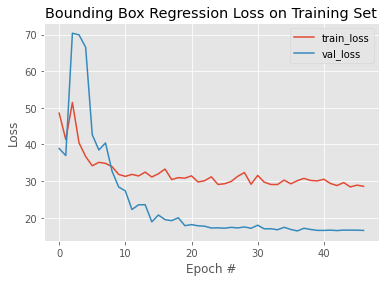

In [110]:
N = len(history.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")


In [111]:
plt.savefig(PLOT_PATH)

<Figure size 432x288 with 0 Axes>

## Predicting with the Trained Model

### Importing Packages

In [112]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import matplotlib.pyplot as plt
import cv2
import os

### Loading Model

In [119]:
model = load_model(MODEL_PATH)

### Visualizing Predictions

In [113]:
imagePaths = open(TEST_FILENAMES).read().strip().split("\n")

In [118]:
dim = (150,150)

for imagePath in imagePaths:
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(os.path.join(IMAGES_PATH,imagePath), target_size=(150, 150))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # make bounding box predictions on the input image
    preds = model.predict(image)[0]
    (startX, startY, endX, endY) = preds

    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(os.path.join(IMAGES_PATH,imagePath))
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)




    # draw the predicted bounding box on the image
    image = cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
    image = imutils.resize(image, width=600)

    # show the output image
    cv2.imshow("Output", image)
    cv2.waitKey(0)